Попробуем несколькими разными способами обсчитать результаты АБ-теста.

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import zt_ind_solve_power
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%config InlineBackend.figure_format = 'retina'

# Загрузка и предобработка данных
game_data = pd.read_csv('cookie_cats.csv')
print(f"Размерность данных: {game_data.shape}")
game_data.rename(columns={
    'userid': 'player_id',
    'version': 'game_version',
    'sum_gamerounds': 'total_rounds',
    'retention_1': 'day1_retention',
    'retention_7': 'day7_retention'
}, inplace=True)

Размерность данных: (90189, 5)


In [64]:
game_data

,player_id,game_version,total_rounds,day1_retention,day7_retention
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


__Описание колонок:__

- `player_id` - уникальный номер, идентифицирующий каждого игрока.
- `game_version` - был ли пользователь отнесен к контрольной группе (`gate_30` - ворота на 30-м уровне) или к тестовой (`gate_40` - ворота на 40-м уровне).
- `total_rounds` - число сессий, сыгранных игроком в течение первых 14 дней после установки игры.
- `day1_retention` - вернулся ли игрок после __первого__ дня с момента установки?
- `day7_retention` - вернулся ли игрок после __седьмого__ дня с момента установки?

Когда игрок устанавливает игру, он/она случайным образом относятся либо к группе `gate_30`, либо `gate_40`. На всякий случай, давайте проверим, действительно ли их примерно поровну в каждой из группу.

In [65]:
def data_health_check(df):
    print("Проверка данных:")
    print(f"Дубликаты: {df.duplicated().sum()}")
    print(f"Пропуски:\n{df.isna().sum()}")
    print("\nОписательная статистика:")
    print(df.describe().T)

data_health_check(game_data)

Проверка данных:
Дубликаты: 0
Пропуски:
player_id         0
game_version      0
total_rounds      0
day1_retention    0
day7_retention    0
dtype: int64

Описательная статистика:
                count          mean           std    min        25%  \
player_id     90189.0  4.998412e+06  2.883286e+06  116.0  2512230.0   
total_rounds  90189.0  5.187246e+01  1.950509e+02    0.0        5.0   

                    50%        75%        max  
player_id     4995815.0  7496452.0  9999861.0  
total_rounds       16.0       51.0    49854.0  


Можно заметить сильную асимметрию: среднее значение (51.88) сильно больше медианы (16). Также 75% игроков играют ≤51 раунд, но максимальное значение — 49854. Можно увидеть, что 50% игроков прекращают игру после 16 раундов.

Благодаря этой статистике можно выделить три группы:

"Новички" (≤5 раундов) — 25% игроков

"Средние" (6-51 раунд) — 50%

"Хардкорные" (>51 раунда) — 25%

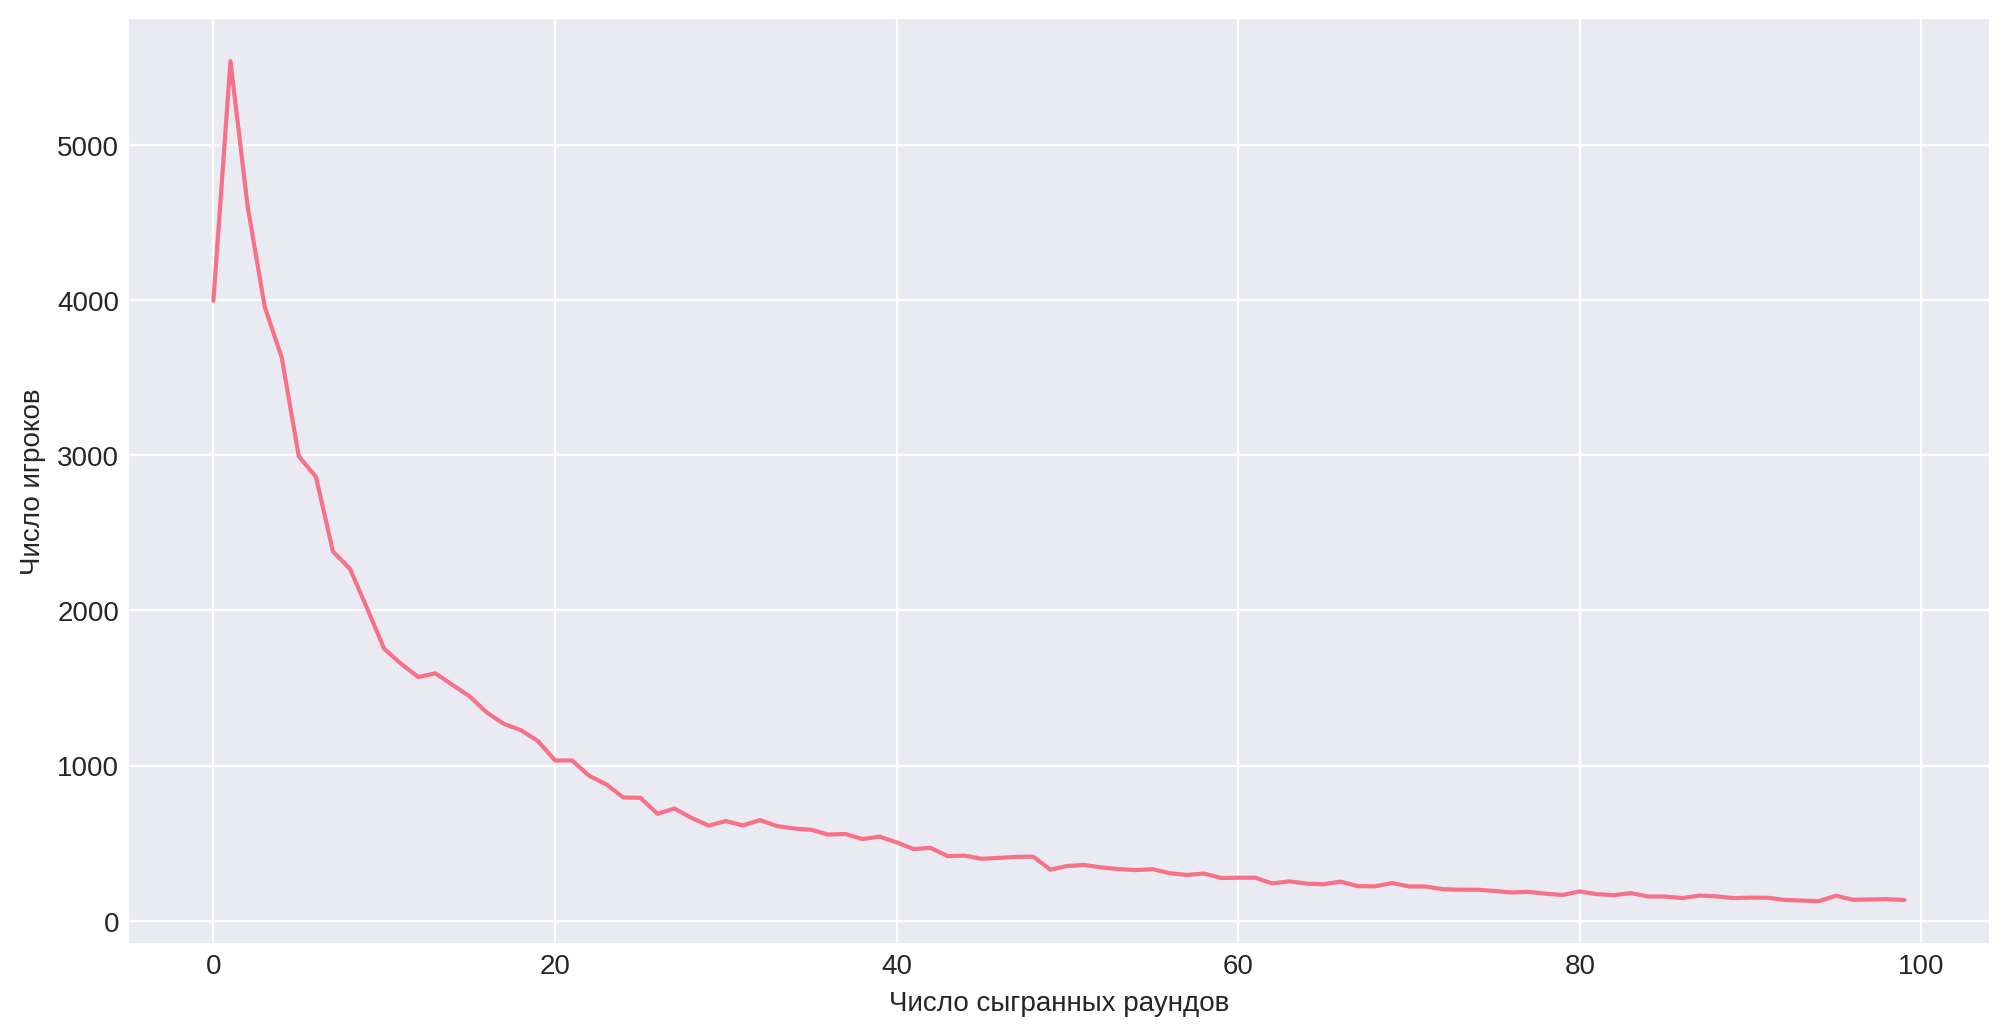

In [66]:
plot_df = game_data.groupby('total_rounds')['player_id'].count()
plt.figure(figsize=(12,6))
ax = plot_df.head(100).plot()
ax.set_xlabel("Число сыгранных раундов")
ax.set_ylabel("Число игроков");

На основе графика можно увидеть, что есть пик на 0, то есть большая часть игроков не начинает играть после установки. Но при этом некоторые пользователи остались играть и дошли до высокого уровня.



Но нам важно, чтобы игрокам была игра интересной и возвращались к ней снова и снова.

Одной из ключевых метрик, используемых в игровой индустрии для оценки увлекательности игры, является удержание первого дня (1-day retention). Эта метрика показывает долю пользователей, которые вернулись к игре спустя сутки после её установки. Чем выше показатель удержания первого дня, тем проще в дальнейшем удерживать аудиторию и расширять базу фанатов.

In [67]:
def calculate_retention_metrics(df, group_col, retention_col):
    """Расчет метрик удержания с доверительными интервалами"""
    result = df.groupby(group_col)[retention_col].agg(
        conversions=('sum'),
        sample_size=('count'),
        retention_rate=('mean')
    ).reset_index()

    # Расчет доверительных интервалов
    ci_low, ci_high = [], []
    for _, row in result.iterrows():
        low, high = proportion_confint(
            count=row['conversions'],
            nobs=row['sample_size'],
            alpha=0.05,
            method='normal'
        )
        ci_low.append(low)
        ci_high.append(high)

    return result

**Анализ удержания на 1 день**

In [68]:
retention_day1 = calculate_retention_metrics(game_data, 'game_version', 'day1_retention')
print("\nАнализ удержания на 1 день:")
print(retention_day1)


Анализ удержания на 1 день:
  game_version  conversions  sample_size  retention_rate
0      gate_30        20034        44700        0.448188
1      gate_40        20119        45489        0.442283


Похоже, что у нас есть небольшое ухудшение в удержании первого дня retention_rate, если мы двигаем ворота к сороковому уровню (44.2%) в сравнении с контрольной группой, где ворота остались на 30-м уровне (44.8%)

Теперь проверим значимость этого эффекта. Будем использовать тест о равенстве долей.

$$
\begin{aligned}
&H_0: \hspace{2mm} p_{40} = p_{30} \\
&H_1: \hspace{2mm} p_{40} < p_{30}
\end{aligned}
$$

> **Предпосылки:** нет выбросов, много наблюдений. Наблюдения независимы. Тогда сможем использовать ЦПТ.

In [69]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05 # уровень значимости = 5%

m_obs = retention_day1.conversions.values
p_obs = retention_day1.retention_rate.values
n_obs = retention_day1.sample_size.values

z_obs, p_val =  proportions_ztest(m_obs,
                                  n_obs,
                                  value=0,
                                  alternative='larger')

print(f"Наблюдаемое значение статистики: {z_obs:.3}")
print(f"P-значение: {p_val:.3}")

Наблюдаемое значение статистики: 1.78
P-значение: 0.0372


 P-значение меньше 0.05, поэтому гипотеза о равенстве отвергается на уровне значимости 5%

Теперь вычислим мошность этого эксперемента

In [70]:
n_30, n_40 = n_obs  # размеры выборок
p_30, p_40 = p_obs  # доли

# дисперсии
var_40, var_30 = p_40 * (1 - p_40), p_30 * (1 - p_30)

# стандартизированный размер эффекта
effect = (p_30 - p_40) / ((n_40* np.sqrt(var_40) + n_30 * np.sqrt(var_30)) / (n_40 + n_30))
effect

0.01188210610259806

Это значение является небольшим, указывающим на слабую разницу между долями
p
30
  и
p
40
 .
Малый размер эффекта означает, что влияние изменения на метрику удержания первого дня минимально.

In [71]:
n_obs[1]/n_obs[0]

1.0176510067114093

Размеры выборок практически одинаковы  

In [72]:
from statsmodels.stats.power import zt_ind_solve_power

zt_ind_solve_power(effect_size=effect,
                   nobs1=sum(n_obs),
                   alpha=0.05,
                   power=None,
                   ratio=n_obs[1]/n_obs[0],
                   alternative='larger')

0.8131005106557109

Мощность теста показывает вероятность того, что тест правильно обнаружит эффект, если он действительно существует. Значение 0.8131 превышает минимально рекомендуемое значение мощности 0.8.

**Анализ удержания на 7 дней**

In [73]:
retention_day7 = calculate_retention_metrics(game_data, 'game_version', 'day7_retention')
print("\nАнализ удержания на 7 дней:")
print(retention_day7)


Анализ удержания на 7 дней:
  game_version  conversions  sample_size  retention_rate
0      gate_30         8502        44700        0.190201
1      gate_40         8279        45489        0.182000


Похоже, что у нас есть небольшое ухудшение в удержании первого дня retention_rate, если мы двигаем к сороковому уровню (18.2%) в сравнении с контрольной группой, где остались на 30-м уровне (19%)

Видим, что удержание 7-го дня в целом ниже, чем удержание 1-го - спустя неделю намного меньше людей всё ещё заходит в игру.

Теперь проверим значимость этого эффекта. Будем использовать тест о равенстве долей.

$$
\begin{aligned}
&H_0: \hspace{2mm} p_{40} = p_{30} \\
&H_1: \hspace{2mm} p_{40} < p_{30}
\end{aligned}
$$

> **Предпосылки:** нет выбросов, много наблюдений. Наблюдения независимы. Тогда сможем использовать ЦПТ.

In [74]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05 # уровень значимости = 5%

m_obs = retention_day7.conversions.values
p_obs = retention_day7.retention_rate.values
n_obs = retention_day7.sample_size.values

z_obs, p_val =  proportions_ztest(m_obs,
                                  n_obs,
                                  value=0,
                                  alternative='larger')

print(f"Наблюдаемое значение статистики: {z_obs:.3}")
print(f"P-значение: {p_val:.3}")

Наблюдаемое значение статистики: 3.16
P-значение: 0.000777


P-значение меньше 0.05, поэтому гипотеза о равенстве отвергается на уровне значимости 5%

Видим, что разница сильно значима. Для 7-дневного удержания произойдёт довольно мощный обвал.

**Выводы**

Результаты A/B-теста демонстрируют, что 7-дневное удержание игроков значительно выше в группе, где ворота установлены на 30-м уровне, по сравнению с группой, где они находятся на 40-м уровне. Следовательно, чтобы сохранить высокий уровень удержания игроков и увеличить их количество, сдвигать ворота с 30-го уровня на 40-й нецелесообразно.

Однако возникает вопрос: почему удержание выше, когда ворота расположены раньше?
- Логично было бы предположить обратное — что более позднее размещение препятствия позволит игрокам дольше взаимодействовать с игрой. Тем не менее, данные показывают противоположное. Для объяснения этой ситуации можно обратиться к концепции гедонистической адаптации. Этот принцип говорит о том, что удовольствие от определенной деятельности снижается, если она длится слишком долго. Размещая ворота на 30-м уровне, мы заставляем игроков сделать паузу, тем самым усиливая их интерес к игре и стимулируя возвращаться к ней. Если же ворота появляются только на 40-м уровне, игроки успевают насытиться игровым процессом и начинают терять к нему интерес.
- Раннее введение ограничений позволяет создать ощущение прогресса, а более позднее препятствие может ощущаться как "потеря мотивации", поскольку игроки могут застрять на более сложных уровнях.

***Примечание***

Так как у нас нет данных, связанных с тем, что часть игроков вообще могла не дойти до ворот, то мы их не учитывали в эксперементе. Но их надо было бы учитывать, если бы они были. То есть надо было бы отфильтровать пользователей, которые не дошли в первый день до 30 уровня.